<a href="https://colab.research.google.com/github/OhOmah/DS-Unit-2-Kaggle-Challenge/blob/master/module3-cross-validation/LS_DS_223_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 3*

---

# Cross-Validation


## Assignment
- [ ] [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Continue to participate in our Kaggle challenge. 
- [ ] Use scikit-learn for hyperparameter optimization with RandomizedSearchCV.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


**You can't just copy** from the lesson notebook to this assignment.

- Because the lesson was **regression**, but the assignment is **classification.**
- Because the lesson used [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html), which doesn't work as-is for _multi-class_ classification.

So you will have to adapt the example, which is good real-world practice.

1. Use a model for classification, such as [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. Use hyperparameters that match the classifier, such as `randomforestclassifier__ ...`
3. Use a metric for classification, such as [`scoring='accuracy'`](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)
4. If you’re doing a multi-class classification problem — such as whether a waterpump is functional, functional needs repair, or nonfunctional — then use a categorical encoding that works for multi-class classification, such as [OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html) (not [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html))



## Stretch Goals

### Reading
- Jake VanderPlas, [Python Data Science Handbook, Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), Hyperparameters and Model Validation
- Jake VanderPlas, [Statistics for Hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers?slide=107)
- Ron Zacharski, [A Programmer's Guide to Data Mining, Chapter 5](http://guidetodatamining.com/chapter5/), 10-fold cross validation
- Sebastian Raschka, [A Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb)
- Peter Worcester, [A Comparison of Grid Search and Randomized Search Using Scikit Learn](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85)

### Doing
- Add your own stretch goals!
- Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/). See the previous assignment notebook for details.
- In additon to `RandomizedSearchCV`, scikit-learn has [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.
- _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?


### BONUS: Stacking!

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [240]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [241]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [242]:
# Making a function that will take out all the nulls and uneeded variables 
import numpy as np 

def wrangle(X):
  # Making a copy of the dataframe
  X.copy()

  # Replacing the werid measurements as zeros 
  X['latitude'] = X['latitude'].replace(-2e-08, 0)

  # Replacing all the 0s with nan values
  zero_cols = ['longitude', 'latitude']
  for col in zero_cols:
    X[col] = X[col].replace(0, np.nan)
  
  # Taking care of the popluation column. 
  pop_zero = ['population']
  for col in pop_zero:
    X[col] = X[col].replace(0, np.nan)

  # Dropping the high cardinatility data columns 
  hc_cols = [col for col in X.describe(include='object').columns
             if X[col].nunique() > 100]
  
  # Dropping the repeated columns and columns I don't need
  X = X.drop(['quantity_group'] + hc_cols, axis=1)
  X = X.drop(['public_meeting', 'population', 'basin', 'recorded_by'], axis=1)
  return X 

In [243]:
# Applying my wrangling function to my training and test dataframes
train = wrangle(train)
test = wrangle(test)

In [244]:
# Now doing my train/validate split 

y = train['status_group']
X = train.drop('status_group', axis=1)

In [245]:
# using train_test_split to make my train and validation data
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=42)

In [246]:
# Now time to build my baseline 
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5429713804713805


In [247]:
# Now it's time to build my model
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler


model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    RandomForestClassifier(),
)

In [248]:
# Fitting my model with the current data
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['region', 'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoint_type_group'...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                  

In [249]:
# checking my metrics
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy: 0.9999789562289563
Validation Accuracy: 0.7968013468013468


In [276]:
# Tuning my model

param = {
    'randomforestclassifier__n_estimators': range(20,120,20),
    'randomforestclassifier__max_depth': range(2,50,2),
    'randomforestclassifier__min_samples_split': range(2,12,2),
    'randomforestclassifier__max_features': range(2,40,2),
}

from sklearn.model_selection import RandomizedSearchCV

rs = RandomizedSearchCV(model,
                        param_distributions=param,
                        scoring='accuracy',
                        n_jobs=1,
                        verbose=1
                        )

In [ ]:
rs.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selectio

In [252]:
rs.best_params_

{'randomforestclassifier__max_depth': 22,
 'randomforestclassifier__min_samples_split': 6,
 'randomforestclassifier__n_estimators': 60}

In [253]:
print('Training Accuracy:', rs.score(X_train, y_train))
print('Validation Accuracy:', rs.score(X_val, y_val))

Training Accuracy: 0.9249579124579125
Validation Accuracy: 0.8021885521885522


In [254]:
X_train.head()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region,region_code,district_code,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
3607,454,50.0,2092,35.426020,-4.227446,0,Manyara,21,1,Water Board,True,1998,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
50870,510,0.0,0,35.510074,-5.724555,0,Dodoma,1,6,VWC,True,0,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,hand pump,hand pump
20413,14146,0.0,0,32.499866,-9.081222,0,Mbeya,12,6,VWC,False,0,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,other
52806,47410,0.0,0,34.060484,-8.830208,0,Mbeya,12,7,VWC,True,0,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
50091,1288,300.0,1023,37.032690,-6.040787,0,Morogoro,5,1,VWC,True,1997,other,other,other,vwc,user-group,pay when scheme fails,on failure,salty,salty,enough,shallow well,shallow well,groundwater,other,other


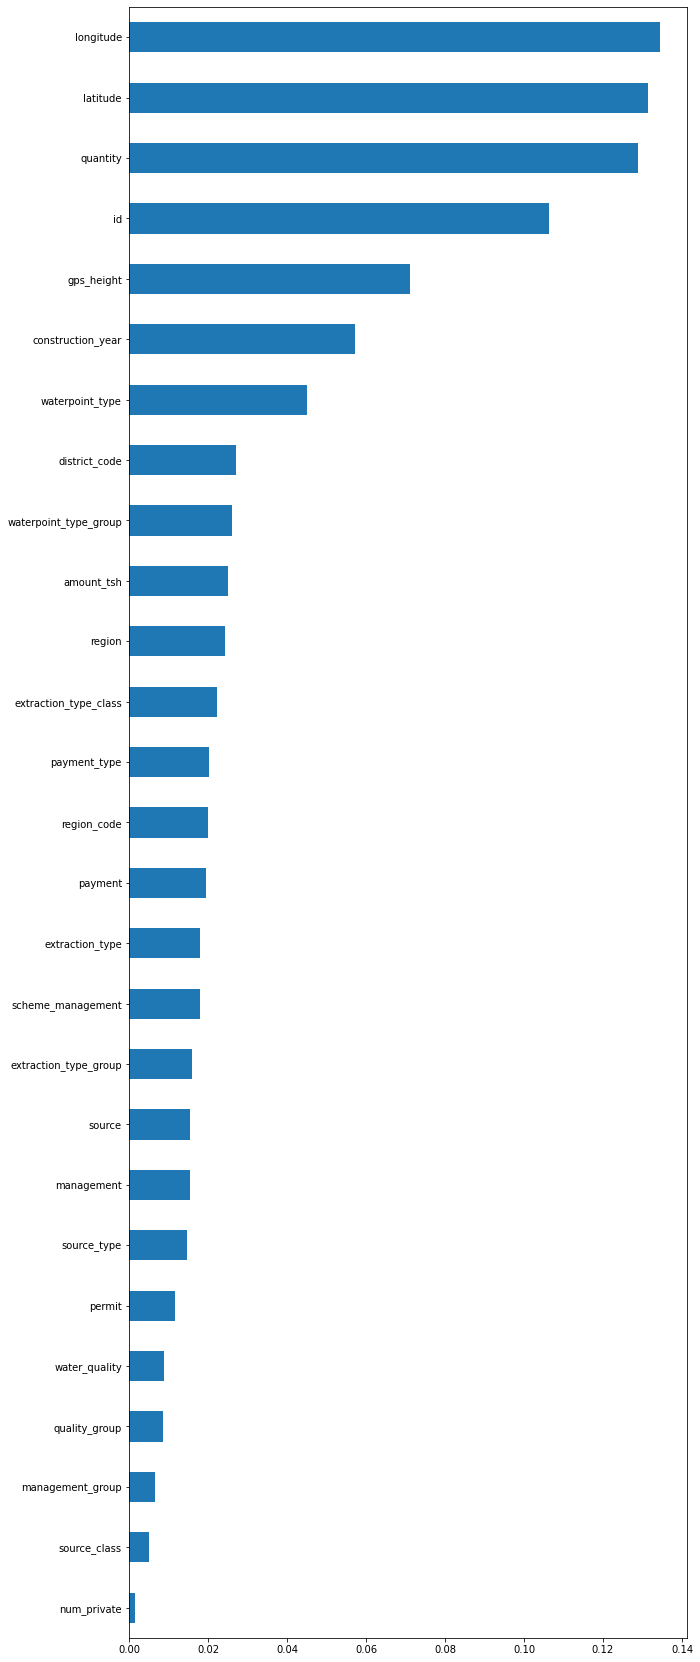

In [255]:
classifier = model.named_steps['randomforestclassifier']
feature_names = model.named_steps['ordinalencoder'].feature_names

# Plotting my feature Importances
feat_importances = classifier.feature_importances_
importantces = pd.Series(feat_importances, index=feature_names)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,30))
importantces.sort_values().plot(kind='barh');

In [263]:
X_test = test

In [264]:
submission_log = sample_submission.copy()

In [269]:
# Getting my predictions to submit to kaggle 
y_pred = rs.predict(X_test)

In [270]:
submission_log['status_group'] = y_pred

In [271]:
submission_log.to_csv('submission_log.csv', index = False)

In [268]:
y_pred

array(['functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

In [262]:
submission_log.shape

(14358, 2)